# Trip Advisor Analysis: Part two - Sentiment Analysis and Product Feature Extraction

In this portion of the project, we will analysis the reviews we scraped from tripadvivors. We have the reviews of over 20 restaurants. Local restaurants can use findings to improve marketing approachs and boost profits. 

 

### Import packages

In [54]:
# basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# text clean 
import string 
import re


## EDA 
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


# text preprocessing  
import nltk
from nltk import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')

# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# feature extracting 
from nltk import pos_tag


### topic modeling - clusters
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy

import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sofia2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
df = pd.read_csv('all_reviews_trip.csv',header=None,names = ['date', 'rating','title','review','restaurant_name'])

In [56]:
df.head()

,date,rating,title,review,restaurant_name
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,I cant find words to describe how amazing this...,Scalini Fedeli
1,16-Aug-21,50,Price fix,What a hidden gem. I have never been here befo...,Scalini Fedeli
2,5-Jan-20,50,Fantastic,A quaint romantic restaurant with a excellent ...,Scalini Fedeli
3,6-Oct-19,50,"Amazing service, superb food",This was recommended to us by some foodie frie...,Scalini Fedeli
4,12-Sep-19,50,Excellence,Civilized and elegant...you can actually hear ...,Scalini Fedeli


In [57]:
df.head()

,date,rating,title,review,restaurant_name
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,I cant find words to describe how amazing this...,Scalini Fedeli
1,16-Aug-21,50,Price fix,What a hidden gem. I have never been here befo...,Scalini Fedeli
2,5-Jan-20,50,Fantastic,A quaint romantic restaurant with a excellent ...,Scalini Fedeli
3,6-Oct-19,50,"Amazing service, superb food",This was recommended to us by some foodie frie...,Scalini Fedeli
4,12-Sep-19,50,Excellence,Civilized and elegant...you can actually hear ...,Scalini Fedeli


### Extract product name from url

In [58]:
df.head(100)

,date,rating,title,review,restaurant_name
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,I cant find words to describe how amazing this...,Scalini Fedeli
1,16-Aug-21,50,Price fix,What a hidden gem. I have never been here befo...,Scalini Fedeli
2,5-Jan-20,50,Fantastic,A quaint romantic restaurant with a excellent ...,Scalini Fedeli
3,6-Oct-19,50,"Amazing service, superb food",This was recommended to us by some foodie frie...,Scalini Fedeli
4,12-Sep-19,50,Excellence,Civilized and elegant...you can actually hear ...,Scalini Fedeli
...,...,...,...,...,...
95,27-Dec-20,50,Best Seafood in Atlanta,Lovely atmosphere. Wonderful seafood. Great at...,The Optimist
96,21-Sep-20,50,Wonderful Seafood and Experience,This restaurant was a very pleasant surprise. ...,The Optimist
97,26-Jan-20,50,Great food and atmosphere,We went on a date night and everything was ste...,The Optimist
98,13-Jan-20,50,"Great food, great atmosphere",Awesome place to eat with a great vibe. I had ...,The Optimist


In [59]:
rating = df.groupby('rating').count()
rating 

,date,title,review,restaurant_name
rating,,,,
10,105,105,105,105
20,59,59,59,59
30,170,170,170,170
40,843,843,843,843
50,3910,3910,3910,3910


### Clean text

In [60]:
stop_words = stopwords.words('english')
new_words = ['food']
stop_words = stop_words + new_words

def clean_text(text):
    text = str(text)
    text = text.replace("-"," ")
    text =  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = text.lower()
    text = text.strip('\n')
    return text
df['review'] = df['title'] + '  ' + df['review']
df['reviews_clean'] = df.review.apply(clean_text)
df['reviews_clean'] = df['reviews_clean'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))


In [61]:
df.head()

,date,rating,title,review,restaurant_name,reviews_clean
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,Amazing Italian chef Michael Cetrulo! I cant ...,Scalini Fedeli,amazing italian chef michael cetrulo cant find...
1,16-Aug-21,50,Price fix,Price fix What a hidden gem. I have never bee...,Scalini Fedeli,price fix hidden gem never lived worked nyc lo...
2,5-Jan-20,50,Fantastic,Fantastic A quaint romantic restaurant with a...,Scalini Fedeli,fantastic quaint romantic restaurant excellent...
3,6-Oct-19,50,"Amazing service, superb food","Amazing service, superb food This was recomme...",Scalini Fedeli,amazing service superb recommended us foodie f...
4,12-Sep-19,50,Excellence,Excellence Civilized and elegant...you can ac...,Scalini Fedeli,excellence civilized elegantyou actually hear ...


### SVM Model

Support Vector Machine (SVM) is a linear model used in classification and regression data problems. In this project, we will use our SVM model to classify the sentiment of our reviews on our label columns named "rating". The SVM model is built on an algorithm that takes an input of vectorized data. It plots the data in n-dimensional space (n being the number of features) and with the value of each feature being its coordinate. 

In this section, we will split our data 80/20 with 80 percent of our dat will traian our model and 20 percent we will use for testing to test its accuracy. Then, the data will be turned into a vector so we can input into our SVM model. We will use the SVM model from the scikit learn library. 

In [137]:
def label(rating):
    if rating == 50 or rating == 40:
        return 'pos'
    else:
        return 'neg'
    
df['label'] = df.rating.apply(label)

In [138]:
df.head()

,date,rating,title,review,restaurant_name,reviews_clean,Predicted,label
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,Amazing Italian chef Michael Cetrulo! I cant ...,Scalini Fedeli,amazing italian chef michael cetrulo cant find...,50,pos
1,16-Aug-21,50,Price fix,Price fix What a hidden gem. I have never bee...,Scalini Fedeli,price fix hidden gem never lived worked nyc lo...,50,pos
2,5-Jan-20,50,Fantastic,Fantastic A quaint romantic restaurant with a...,Scalini Fedeli,fantastic quaint romantic restaurant excellent...,50,pos
3,6-Oct-19,50,"Amazing service, superb food","Amazing service, superb food This was recomme...",Scalini Fedeli,amazing service superb recommended us foodie f...,40,pos
4,12-Sep-19,50,Excellence,Excellence Civilized and elegant...you can ac...,Scalini Fedeli,excellence civilized elegantyou actually hear ...,40,pos


In [144]:
from sklearn.model_selection import train_test_split

X = df['reviews_clean']
y = df['rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)


In [146]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score



# Perform classification with SVM, kernel=poly
classifier_linear = svm.SVC(kernel='poly')
t0 = time.time()
classifier_linear.fit(train_vectors, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test, prediction_linear, output_dict=True)
# print('positive: ', report[50])
# print('negative: ', report[10])
poly_pred = classifier_linear.predict(test_vectors)
poly_accuracy = accuracy_score(y_test, poly_pred)

print(report)


print('\nAccuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))

Training time: 2.115167s; Prediction time: 0.187442s
{'10': {'precision': 1.0, 'recall': 0.8823529411764706, 'f1-score': 0.9375, 'support': 17}, '20': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, '30': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 20}, '40': {'precision': 1.0, 'recall': 0.7818181818181819, 'f1-score': 0.8775510204081634, 'support': 110}, '50': {'precision': 0.9429590017825312, 'recall': 1.0, 'f1-score': 0.9706422018348625, 'support': 529}, 'accuracy': 0.9530791788856305, 'macro avg': {'precision': 0.9885918003565063, 'recall': 0.8495008912655972, 'f1-score': 0.9103853976953584, 'support': 682}, 'weighted avg': {'precision': 0.9557555893591774, 'recall': 0.9530791788856305, 'f1-score': 0.9509314363826141, 'support': 682}}

Accuracy (Polynomial Kernel):  95.31


### ROC curve

Roc curve is popular way to graph the performance of your classification model and all of the different thersholds. 

<b>This is a graph of when the model was trained on a binary classification and does not represent the multi-classification.</b>

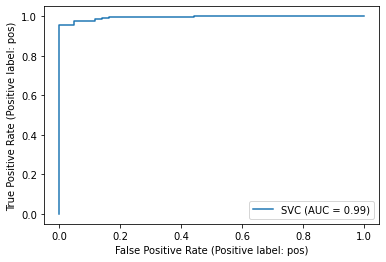

In [142]:
from sklearn import datasets, metrics
metrics.plot_roc_curve(classifier_linear, test_vectors, y_test)

In [125]:
df = df.head(3408)
df['Predicted'] = classifier_linear.predict(train_vectors)

In [126]:
df.head()

,date,rating,title,review,restaurant_name,reviews_clean,Predicted
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,Amazing Italian chef Michael Cetrulo! I cant ...,Scalini Fedeli,amazing italian chef michael cetrulo cant find...,50
1,16-Aug-21,50,Price fix,Price fix What a hidden gem. I have never bee...,Scalini Fedeli,price fix hidden gem never lived worked nyc lo...,50
2,5-Jan-20,50,Fantastic,Fantastic A quaint romantic restaurant with a...,Scalini Fedeli,fantastic quaint romantic restaurant excellent...,50
3,6-Oct-19,50,"Amazing service, superb food","Amazing service, superb food This was recomme...",Scalini Fedeli,amazing service superb recommended us foodie f...,40
4,12-Sep-19,50,Excellence,Excellence Civilized and elegant...you can ac...,Scalini Fedeli,excellence civilized elegantyou actually hear ...,40


In [127]:

df_positive = df[(df['Predicted'] == 50 )| (df['Predicted'] == 40)]

In [128]:
df_positive.head()

,date,rating,title,review,restaurant_name,reviews_clean,Predicted
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,Amazing Italian chef Michael Cetrulo! I cant ...,Scalini Fedeli,amazing italian chef michael cetrulo cant find...,50
1,16-Aug-21,50,Price fix,Price fix What a hidden gem. I have never bee...,Scalini Fedeli,price fix hidden gem never lived worked nyc lo...,50
2,5-Jan-20,50,Fantastic,Fantastic A quaint romantic restaurant with a...,Scalini Fedeli,fantastic quaint romantic restaurant excellent...,50
3,6-Oct-19,50,"Amazing service, superb food","Amazing service, superb food This was recomme...",Scalini Fedeli,amazing service superb recommended us foodie f...,40
4,12-Sep-19,50,Excellence,Excellence Civilized and elegant...you can ac...,Scalini Fedeli,excellence civilized elegantyou actually hear ...,40


In [70]:
rating = df_positive.groupby('rating').count()
rating 

,date,title,review,restaurant_name,reviews_clean,Predicted
rating,,,,,,
10,66,66,66,66,66,66
20,25,25,25,25,25,25
30,104,104,104,104,104,104
40,462,462,462,462,462,462
50,2549,2549,2549,2549,2549,2549


In [71]:
df_positive.shape

(3206, 7)

In [72]:
df_positive = df[(df['rating'] == 50) | (df['rating'] == 40)]

In [73]:
df_positive.shape

(3199, 7)

In [74]:

df_negative = df[(df['Predicted'] == 10 )| (df['Predicted'] == 20)]

In [75]:
df_negative.head()

,date,rating,title,review,restaurant_name,reviews_clean,Predicted
34,26-Dec-15,50,A wonderful gem but hard to find!,A wonderful gem but hard to find! We walked f...,Scalini Fedeli,wonderful gem hard find walked hour dark tryin...,10
44,12-Dec-21,50,Amazing brunch! We loved it so much! The biscu...,Amazing brunch! We loved it so much! The biscu...,South City Kitchen Midtown,amazing brunch loved much biscuits grits yummm...,20
54,16-Feb-20,50,Great Experience,Great Experience This was my first visit to S...,South City Kitchen Midtown,great experience first visit south city kitche...,10
107,19-Jun-19,40,"Fresh food, friendly atmosphere!","Fresh food, friendly atmosphere! Seafood is f...",The Optimist,fresh friendly atmosphere seafood fresh made o...,20
137,20-Apr-22,50,What an amazing experience!!,What an amazing experience!! We had such an a...,Hard Rock Cafe,amazing experience amazing time i’d definitely...,10


In [76]:
df_negative.shape

(102, 7)

In [77]:
rating = df_negative.groupby('rating').count()
rating 

,date,title,review,restaurant_name,reviews_clean,Predicted
rating,,,,,,
20,3,3,3,3,3,3
30,1,1,1,1,1,1
40,13,13,13,13,13,13
50,85,85,85,85,85,85


In [78]:
df_negative = df[(df['rating'] == 10) | (df['rating'] == 20)]

In [79]:
df_negative.shape

(98, 7)

### Anaylsis of SVM

It appears that the model had a more difficult time predicting on the negative reviews. I believe this is mainly do the the imbalancce in the dataset.

### Positive Reviews Topic Modeling Analysis - LDA: Clustering 

<b> What is Latent Dirichlet Allocation (LDA)? </b> 

LDA is a popular unsupervised machine learning model used to classify different topics found in a corpus. A corpus is a collection of machine-readable texts that have been produced in a natural communicative setting. [2] After text is preprocessed, we will used the tokened data to input into our model. We will count the term frequency of our corpus and then use it as our input data. We also created a dictionary for our term for our analysis after the modeling is done. 


After the text data is preprocessed, it is turn into a document term matrix. Once the data is inputed into the model it goes through the following steps: 

1. Dirichlet Parameter
2. Document - topic distribution 
3. Word-topic assignment
4. Observed word
5. Topic-word distribution 
6. Dirichlet Parameter

This is also know as the Vector space of LDA. 

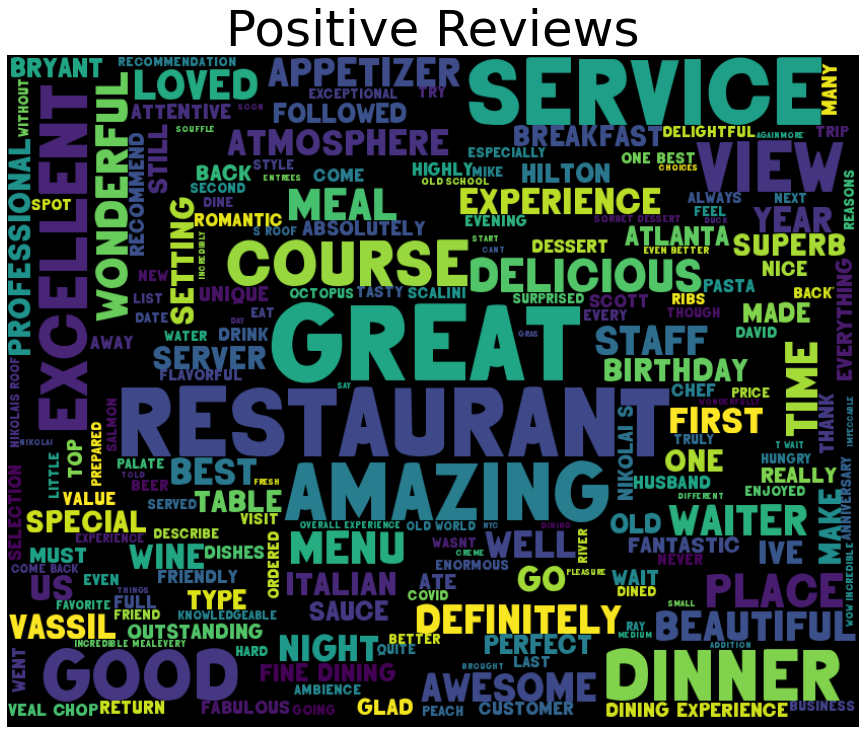

In [81]:
words = df_positive['reviews_clean']
font_path = 'Midnight.ttf'
mask = np.array(Image.open('cloud_2.png'))
mostcommon = FreqDist(words).most_common(100)
wordcloud = WordCloud(mask = mask, background_color = 'black', font_path = font_path, random_state = 42,
                      width = mask.shape[1], height = mask.shape[0]).generate(str(mostcommon))

fig = plt.figure(figsize=(30,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Reviews', fontsize=50)
plt.tight_layout(pad=0)
plt.show()



### Tokenize Text

In [82]:


from nltk.tokenize import word_tokenize
def nouns(text):
    text = ' '.join([w for w in text.split() if len(w) > 1])
    text = word_tokenize(text)
  
    text = str(text)
    return text


df_positive['review_token'] = df_positive.reviews_clean.apply(nouns)

/var/folders/73/1p1wks3j7p31_q_16bs_12140000gq/T/ipykernel_16011/3410072813.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['review_token'] = df_positive.reviews_clean.apply(nouns)


In [114]:
common = pd.Series(' '.join(df_positive['reviews_clean']).split()).value_counts()[:35]
print(common)


great         2345
service       1685
good          1134
restaurant     891
excellent      833
place          817
best           720
amazing        715
delicious      696
dinner         647
atlanta        504
experience     494
atmosphere     466
staff          462
time           422
sushi          404
back           396
wonderful      391
go             387
chicken        378
nice           373
menu           373
definitely     330
well           322
wait           321
friendly       320
meal           310
always         309
would          304
awesome        297
one            292
recommend      290
really         274
dining         273
fantastic      246
dtype: int64


In [83]:
df_positive.head()

,date,rating,title,review,restaurant_name,reviews_clean,Predicted,review_token
0,6-Mar-22,50,Amazing Italian chef Michael Cetrulo!,Amazing Italian chef Michael Cetrulo! I cant ...,Scalini Fedeli,amazing italian chef michael cetrulo cant find...,50,"['amazing', 'italian', 'chef', 'michael', 'cet..."
1,16-Aug-21,50,Price fix,Price fix What a hidden gem. I have never bee...,Scalini Fedeli,price fix hidden gem never lived worked nyc lo...,50,"['price', 'fix', 'hidden', 'gem', 'never', 'li..."
2,5-Jan-20,50,Fantastic,Fantastic A quaint romantic restaurant with a...,Scalini Fedeli,fantastic quaint romantic restaurant excellent...,50,"['fantastic', 'quaint', 'romantic', 'restauran..."
3,6-Oct-19,50,"Amazing service, superb food","Amazing service, superb food This was recomme...",Scalini Fedeli,amazing service superb recommended us foodie f...,40,"['amazing', 'service', 'superb', 'recommended'..."
4,12-Sep-19,50,Excellence,Excellence Civilized and elegant...you can ac...,Scalini Fedeli,excellence civilized elegantyou actually hear ...,50,"['excellence', 'civilized', 'elegantyou', 'act..."


### Create list of text values for topic modeling 

In [84]:
df_positive_2 = df_positive.loc[df_positive.review_token.apply(lambda reviews: reviews !=[]),['review_token']]

reviews = df_positive_2.review_token.values.tolist()

In [85]:

reviews = [str(r).split(',') for r in reviews]

### Create Dictionary of text

In [86]:
id2word = Dictionary(reviews) 

### Converts tokenized text to vectors

"doc2bow" simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector

In [87]:
#term frequency document 

corpus = [id2word.doc2bow(text) for text in reviews]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]]


In [88]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]


[[(" 'amazing'", 1),
  (" 'cant'", 1),
  (" 'cetrulo'", 1),
  (" 'chef'", 2),
  (" 'delicious'", 1),
  (" 'describe'", 1),
  (" 'family'", 1),
  (" 'find'", 1),
  (" 'great'", 1),
  (" 'highly'", 1),
  (" 'inventive'", 1),
  (" 'italian'", 1),
  (" 'list'", 1),
  (" 'michael'", 1),
  (" 'professional'", 1),
  (" 'recommend']", 1),
  (" 'restaurant'", 1),
  (" 'soo'", 1),
  (" 'staff'", 1),
  (" 'superb'", 1),
  (" 'talented'", 1),
  (" 'welcoming'", 1),
  (" 'went'", 1),
  (" 'wine'", 1),
  (" 'words'", 1),
  ("['amazing'", 1)]]

In [89]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=7, 
                   random_state=42,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*" \'good\'" + 0.029*" \'chicken\'" + 0.026*" \'fried\'" + 0.020*" '
  '\'bbq\'" + 0.015*" \'brisket\'" + 0.014*" \'place\'" + 0.014*" \'great\'" + '
  '0.014*" \'ribs\'" + 0.013*" \'nice\'" + 0.010*" \'southern\'"'),
 (1,
  '0.059*" \'great\'" + 0.036*" \'service\'" + 0.022*" \'atlanta\'" + 0.018*" '
  '\'good\'" + 0.017*" \'menu\'" + 0.016*" \'also\'" + 0.014*" \'worth\'" + '
  '0.013*" \'always\'" + 0.013*" \'lunch\'" + 0.012*" \'place\'"'),
 (2,
  '0.033*" \'’\'" + 0.028*" \'best\'" + 0.020*" \'service\'" + 0.019*" '
  '\'wait\'" + 0.018*" \'breakfast\'" + 0.016*" \'awesome\'" + '
  '0.015*"[\'great\'" + 0.015*" \'atmosphere\'" + 0.015*" \'s\'" + 0.013*" '
  '\'made\'"'),
 (3,
  '0.035*" \'great\'" + 0.035*" \'service\'" + 0.024*" \'dinner\'" + 0.019*" '
  '\'excellent\'" + 0.015*" \'go\'" + 0.015*" \'amazing\'" + 0.015*" '
  '\'definitely\'" + 0.014*" \'delicious\'" + 0.014*" \'time\'" + 0.012*" '
  '\'experience\'"'),
 (4,
  '0.052*" \'beer\'" + 0.028*" \'good\'" + 0

In [90]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)


\nCoherence Score:  0.3083737704004693


In [91]:
# pyLDAvis.enable_notebook()
# p = gensimvis.prepare(lda_model, corpus, id2word)
# p

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization - converts text to numeric ie vector form 
# Token_Pattern - Regular expression denoting what constitutes a “token”

vectorizer = CountVectorizer(max_df=0.9, min_df=2)

# apply transformation  - tf is term_frequency 
df_positive['review_token'] = df_positive.review_token.apply(lambda x: str(x))
tf = vectorizer.fit_transform(df_positive['review_token']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()


/var/folders/73/1p1wks3j7p31_q_16bs_12140000gq/T/ipykernel_16011/2142581712.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['review_token'] = df_positive.review_token.apply(lambda x: str(x))


In [93]:
from sklearn.decomposition import LatentDirichletAllocation #LDA

number_of_topics = 5

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=42, max_iter =100)

In [94]:
model.fit(tf)

LatentDirichletAllocation(max_iter=100, n_components=5, random_state=42)

In [95]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [96]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,service,648.0,great,301.4,great,363.5,great,402.8,great,660.4
1,great,619.9,service,279.5,good,334.6,good,311.5,service,391.5
2,restaurant,484.9,chicken,273.0,service,126.9,service,242.1,excellent,233.5
3,excellent,390.5,amazing,243.4,restaurant,114.7,place,195.8,best,212.0
4,dinner,338.3,best,229.8,years,105.2,delicious,187.6,place,204.4
5,place,255.8,good,226.6,time,97.0,wait,125.5,experience,189.7
6,best,234.7,dinner,201.4,loved,94.5,chicken,104.9,atmosphere,172.7
7,atlanta,202.4,fried,195.4,delicious,86.0,amazing,102.5,wonderful,169.6
8,amazing,193.8,delicious,145.0,beer,81.3,would,95.6,menu,168.3
9,sushi,185.4,sushi,129.7,would,69.2,nice,93.9,friendly,166.9


### Positive review analysis

This analysis contains all features. We can see that the adjective is weighted much more probably for it frequency in multiple concept. 

Listed below of some of the topic we saw in our positive review analysis: 

1. Service 
2. atmosphere 
3. chicken dishes 
4. location
5. beer 

Restaurtant can take this information to improve upon their strategies. 

### Negative Reviews Topic Modeling Analysis - LDA: Clustering 

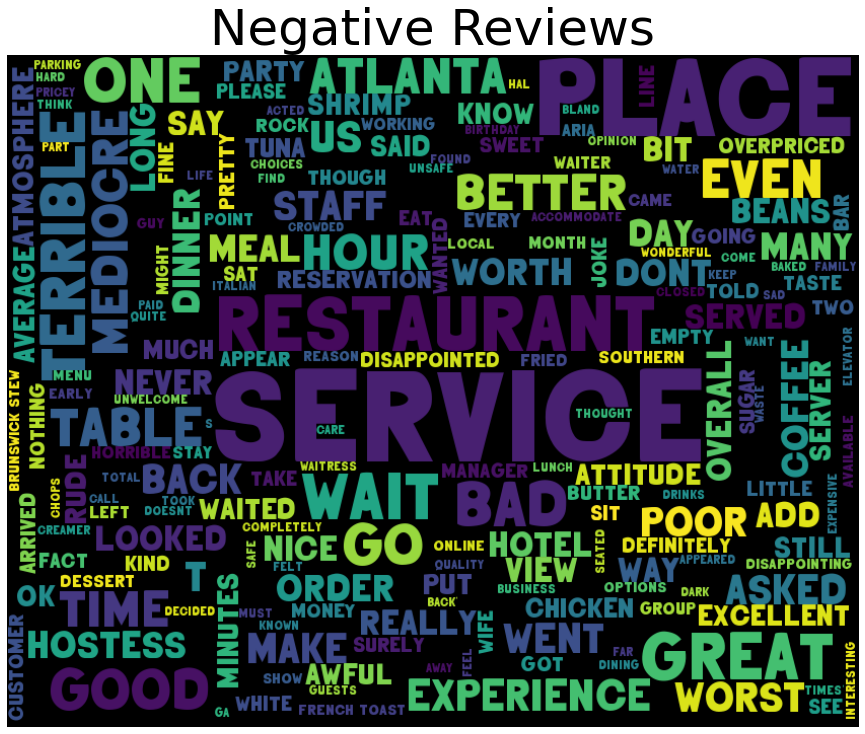

In [97]:
words = df_negative['reviews_clean']



mostcommon = FreqDist(words).most_common(100)

wordcloud = WordCloud(mask = mask, background_color = 'black', font_path = font_path, random_state = 42, 
                      width = mask.shape[1], height = mask.shape[0]).generate(str(mostcommon))


fig = plt.figure(figsize= (30,10))
plt.imshow(wordcloud,interpolation="bilinear" )
plt.axis('off')                  
plt.title('Negative Reviews', fontsize=50)
plt.tight_layout(pad=0)
plt.show()          
                      

### Tokenize Text

In [98]:
from nltk.tokenize import word_tokenize
def nouns(text):
    text = ' '.join([w for w in text.split() if len(w) > 1])
    text = word_tokenize(text)
    return text


df_negative['review_token'] = df_negative.reviews_clean.apply(nouns)

/var/folders/73/1p1wks3j7p31_q_16bs_12140000gq/T/ipykernel_16011/3972684214.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative['review_token'] = df_negative.reviews_clean.apply(nouns)


In [99]:
df_negative.head()

,date,rating,title,review,restaurant_name,reviews_clean,Predicted,review_token
9,6-Nov-18,10,Please close,Please close Total outdated restaurnt with ve...,Scalini Fedeli,please close total outdated restaurnt mediocre...,50,"[please, close, total, outdated, restaurnt, me..."
139,26-Dec-21,10,Soheil Kashani,Soheil Kashani Hard Rock is NOT the same as b...,Hard Rock Cafe,soheil kashani hard rock bad customer service ...,50,"[soheil, kashani, hard, rock, bad, customer, s..."
141,2-Dec-21,10,What a Joke!!,What a Joke!! We went here on a family vacati...,Hard Rock Cafe,joke went family vacationtried get scamed loca...,50,"[joke, went, family, vacationtried, get, scame..."
148,11-May-21,10,Tour,"Tour Sales people are horrible, they will har...",Hard Rock Cafe,tour sales people horrible harass death buy ki...,50,"[tour, sales, people, horrible, harass, death,..."
166,14-Oct-19,10,Stay away!,"Stay away! Dirty place, bad atmosphere, terri...",Hard Rock Cafe,stay away dirty place bad atmosphere terrible ...,50,"[stay, away, dirty, place, bad, atmosphere, te..."


In [115]:
common = pd.Series(' '.join(df_negative['reviews_clean']).split()).value_counts()[:35]
print(common)


service       49
restaurant    47
great         33
place         31
like          30
get           27
terrible      26
one           23
wait          22
go            21
appears       20
dark          20
closed        20
bad           16
better        16
good          16
went          16
looked        15
atlanta       15
mediocre      15
hotel         15
would         15
coffee        13
many          13
even          13
hours         13
2             12
elevator      12
view          12
staff         12
back          12
quite         11
make          11
served        11
hostess       11
dtype: int64


In [100]:
df_negative_2 = df_negative.loc[df_negative.review_token.apply(lambda reviews: reviews !=[]),['review_token']]

reviews = df_negative_2.review_token.values.tolist()

In [108]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization - converts text to numeric ie vector form 
# Token_Pattern - Regular expression denoting what constitutes a “token”

vectorizer = CountVectorizer(max_df=0.9, min_df=2)

# apply transformation  - tf is term_frequency 
df_negative_2['review_token'] = df_negative_2.review_token.apply(lambda x: str(x))
tf = vectorizer.fit_transform(df_negative_2['review_token']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()


### Kmeans clustering to find topic numbers

For this section, I decided to see if we could derive any insights by using kmeans clustering. This can be helpful when try to decide how many topics you should chose for your LDA model. The graph shows that 2 might be the optimal number. However, I chose four because I felt there was still value in the additional 2 topic clusters. 

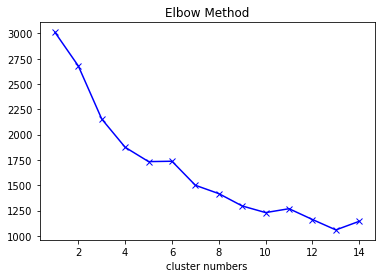

In [148]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

K = range(1,15)
SSE = []
for k in K:
    kmeans = MiniBatchKMeans(n_clusters = k,batch_size = 300)
    kmeans.fit(tf)
    SSE.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(K,SSE,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [158]:
from sklearn.decomposition import LatentDirichletAllocation #LDA

number_of_topics = 4

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=42)

In [159]:
model.fit(tf)

LatentDirichletAllocation(n_components=4, random_state=42)

In [160]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [161]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,service,22.3,one,13.4,service,7.3,restaurant,35.5
1,place,15.5,coffee,13.2,one,4.8,great,24.0
2,good,14.0,service,12.7,go,4.6,closed,20.2
3,like,13.8,like,12.5,restaurant,4.4,appears,20.2
4,terrible,13.3,place,12.2,atmosphere,4.3,dark,20.2
5,bad,12.1,would,12.0,atlanta,4.3,go,12.4
6,better,9.9,wait,11.3,went,4.3,completely,11.2
7,overpriced,9.2,hours,11.3,many,4.3,hotel,11.0
8,really,8.3,staff,10.2,aria,4.3,get,10.5
9,mediocre,8.2,nice,9.3,restaurants,4.3,elevator,10.3


### Negative Review Anaylsis 

Some important finding for the negative review were simliar and different than the positive reviews. People seemed to express more specifics in the negative reviews. 

We also all the following topics customers found important: 
1. Service 
2. Pricing
3. coffee drinks
4. wait times
5. atomophere

## Final Analysis 

This type of analysis can provide powerful insights for a restaurant. This particular project looked at all the features, but a business can adjust the approach for their needs. We know that it will positively or negatively impact a customer’s experience if the restaurant was too dark or had an inviting atmosphere. Also, wait times came up as an important impact on negative reviews. A company could market coupon’s on their least busiest days. 


sources:


    * https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
    *https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/#:~:text=LDA%20operates%20in%20the%20same,is%20a%20matrix%20factorization%20technique.
    * https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1